<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/barebone_xgboost/predict_future_sales_barebone_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

# Imports and uploads

In [1]:
# imports
import os

import gc

import time

import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import tensorflow as tf


#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#encoders, tested several of them
from sklearn.preprocessing import OrdinalEncoder # remove later, don't use this
from sklearn.preprocessing import LabelEncoder # remove later, don't use this
from sklearn.preprocessing import OneHotEncoder # probably don't use this, instead use pd.get_dummies
from sklearn.feature_extraction import FeatureHasher

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline


from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

from sklearn import linear_model

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance


# root path for running on Google Colab
root_path = 'drive/MyDrive/Camp Jupyter/predict_future_sales_data/kaggle_data/'


# Google Colab mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing All Predict Sales Data

In [2]:
#importing all the data frames



# root path for running locally
# sumeet root_path
#root_path='./'
# chris root_path
#root_path = '/Users/cman/Desktop/商务/datasets/predict_future_sales/'

itemcats_df = pd.read_csv(root_path+"item_categories.csv", encoding= 'unicode_escape') #Item Categories
items_df = pd.read_csv(root_path+"items.csv", encoding= 'unicode_escape') # Items
salestrain_df = pd.read_csv(root_path+"sales_train.csv", encoding= 'unicode_escape') #Sales Data - Training
salestrain_df.date = pd.to_datetime(salestrain_df.date)
shops_df = pd.read_csv(root_path+"shops.csv", encoding= 'unicode_escape') # Shops
usd_rus_df = pd.read_csv(root_path+'USD-RUS.csv')
usd_rus_df.Date = pd.to_datetime(usd_rus_df.Date)

# sample submission dataframe
sample_df = pd.read_csv(root_path+'sample_submission.csv')

# test data frame
test_df = pd.read_csv(root_path+'test.csv')

In [3]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df, on = 'item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df, on = 'item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df, on = 'shop_id')

# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue column
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day

# adding a random feature
salestrain_df_combined['Random'] = salestrain_df_combined.apply(lambda x: np.random.randint(100),axis = 'columns')

# creating a new feature: 'month-year'
salestrain_df_combined['month-year'] = salestrain_df_combined['date'].apply(lambda x: str(x.month) + '-' + str(x.year) if x.month >= 10 else '0' + str(x.month) + '-' + str(x.year)) 

##Merging USD - RUS currency conversion to salestrain_df_combined

In [4]:
# merging exchange rate data to master dataframe
salestrain_df_combined = salestrain_df_combined.merge(usd_rus_df[['Date','Open']], left_on = 'date', right_on = 'Date')

In [5]:
# dropping the duplicated date col from 
salestrain_df_combined.drop(['Date'], axis = 'columns', inplace = True)

In [6]:
# renaming the 'Open' col to 'USD_RUS' from the USD RUS conversion dataframe
salestrain_df_combined.rename({'Open':'USD_RUS'}, axis = 'columns', inplace = True)

In [7]:
# caltulating the price based on the conversion rate
salestrain_df_combined['USD_Price'] = salestrain_df_combined['item_price'] / salestrain_df_combined['USD_RUS']

In [8]:
# checking the df head
salestrain_df_combined.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,Random,month-year,USD_RUS,USD_Price
0,2013-02-01,0,59,22154,999.00,1.0,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.00,3,02-2013,29.9816,33.320437
1,2013-02-01,0,59,17482,599.38,1.0,PROMETEY (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,599.38,37,02-2013,29.9816,19.991595
2,2013-02-01,0,59,16626,312.03,1.0,OPINION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,312.03,5,02-2013,29.9816,10.407383


## Remove Outliers above 600 sales per day

In [9]:
for i in range(0,22):
    print(i,len(salestrain_df_combined[salestrain_df_combined['item_cnt_day']> i * 100]))

0 1921686
1 130
2 34
3 21
4 17
5 11
6 5
7 2
8 2
9 2
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1


In [10]:
salestrain_df_combined = salestrain_df_combined[salestrain_df_combined['item_cnt_day'] <= 600]

In [11]:
salestrain_df_combined['month_id'] = (salestrain_df_combined['year'] - 2014) * 12 + salestrain_df_combined['month']

In [12]:
salestrain_df_combined[(salestrain_df_combined['month']==5) & (salestrain_df_combined['year'] == 2015)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,Random,month-year,USD_RUS,USD_Price,month_id
396553,2015-05-28,28,59,12804,148.0,1.0,The Lion King (BD + DVD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2015,5,28,148.0,84,05-2015,50.513,2.929939,17
396554,2015-05-28,28,59,2550,299.0,1.0,DEEP PURPLE The Best Of,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2015,5,28,299.0,17,05-2015,50.513,5.919268,17
396555,2015-05-28,28,59,7493,349.0,1.0,V / A Trance Essentials 2015 1 2CD (digipack),55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2015,5,28,349.0,88,05-2015,50.513,6.909113,17
396556,2015-05-28,28,59,5336,299.0,1.0,OST Furious 7,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2015,5,28,299.0,76,05-2015,50.513,5.919268,17
396557,2015-05-28,28,59,6312,299.0,1.0,SNOOP DOGG Bush,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2015,5,28,299.0,60,05-2015,50.513,5.919268,17


#creating pivot table on 'month' and 'year' columns

item_sales_by_month = salestrain_df_combined.pivot_table(index = 'item_id', columns = ['month', 'year'], values = 'item_cnt_day', aggfunc = np.sum)

## filling in all null values with 0
item_sales_by_month.fillna(0, inplace = True)

## checking head of the pivot table
item_sales_by_month.head()

There were two sales of item id 1 in month 4 of year 2014

## unstacking the pivot table above and resetting the index
item_sales_by_month = item_sales_by_month.unstack().reset_index()

## checking new df head - note strange 0 column
item_sales_by_month.head()

## renaming strange 0 columm to 'Item_Sales_This_Month?' - need clarification on column name
item_sales_by_month.rename({0:'Item_Sales_This_Month'}, axis = 'columns', inplace = True)

## sorting table by item_id then year then month
item_sales_by_month.sort_values(by = ['item_id','year','month'], inplace = True)

## checking modified df
item_sales_by_month.head()

item_sales_by_month.item_id.nunique()

## Check to make sure we have 36*item_id number of rows - one for each month in 2015-2015
len(item_sales_by_month)/21059

## creating new column lags for 1, 2, 3, 6, 12 months
for i in [1, 2, 3, 6, 12]:
  item_sales_by_month[str(i)+'_month_ago'] = item_sales_by_month['Item_Sales_This_Month'].shift(i)

## checking newly added lags on item id '22167' because it has a lot of sales and we can see values clearly
item_sales_by_month[item_sales_by_month.item_id == 22167].head(13)

item_sales_by_month = item_sales_by_month[item_sales_by_month['year'] > 2013]

In [13]:
#item_sales_by_month['month_id'] = item_sales_by_month.apply(lambda x: x.month + (x.year - 2013) * 12, axis=1)

In [14]:
#item_sales_by_month = item_sales_by_month[['1_month_ago', '2_month_ago', '3_month_ago','6_month_ago', '12_month_ago', 'month_id', 'month', 'year', 'item_id', 'Item_Sales_This_Month']].astype(int)

In [15]:
#item_sales_by_month.head(10)

# Lagging Features

*   Item Sales Lag (1, 2, 3, 6 , 12 months)
*   Combination of Items and Shops
*   Shop Sales Lag
*   Shop-Category Lag

## creating lag features based on date

## creating store_id + item_id based lag features

In [17]:
salestrain_df_combined.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
item_name                     object
item_category_id               int64
item_category_name            object
shop_name                     object
year                           int64
month                          int64
day                            int64
revenue                      float64
Random                         int64
month-year                    object
USD_RUS                      float64
USD_Price                    float64
month_id                       int64
dtype: object

In [21]:
# changing data types to save space
salestrain_df_combined.astype({'date_block_num': 'int16', 'shop_id':'int16', 'item_id':'int16', 'item_price':'float16', 'item_cnt_day':'float16', 
                              'item_category_id':'int16', 'year':'int16', 'month':'int16', 'day':'int16', 'revenue':'float16', 'Random':'int16', 
                              'USD_RUS':'float16', 'USD_Price':'float16', 'month_id':'int16'})

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue,Random,month-year,USD_RUS,USD_Price,month_id
0,2013-02-01,0,59,22154,999.0,1.0,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0,3,02-2013,29.984375,33.312500,-10
1,2013-02-01,0,59,17482,599.5,1.0,PROMETEY (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,599.5,37,02-2013,29.984375,19.984375,-10
2,2013-02-01,0,59,16626,312.0,1.0,OPINION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,312.0,5,02-2013,29.984375,10.406250,-10
3,2013-02-01,0,59,17491,199.0,1.0,PROFESSIONAL (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,199.0,51,02-2013,29.984375,6.636719,-10
4,2013-02-01,0,59,8714,199.0,1.0,NO COMPROMISES (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,199.0,52,02-2013,29.984375,6.636719,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927068,2013-01-01,0,14,16203,599.0,1.0,"Board game Russkiy Preferans, art. 1969",64,Gifts - Board Games,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,599.0,19,01-2013,30.500000,19.640625,-11
1927069,2013-01-01,0,14,15438,599.0,1.0,Toy Sojuzmultfilm Pooh music,63,Gifts - Soft Toys,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,599.0,66,01-2013,30.500000,19.640625,-11
1927070,2013-01-01,0,14,9362,299.0,1.0,Keychain Sochi 2014 White bear with scarf 12cm,70,Gifts - Souvenirs (weighed in),"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,299.0,77,01-2013,30.500000,9.804688,-11
1927071,2013-01-01,0,14,22088,79.0,2.0,Battery DURACELL LR06-BC2,83,batteries,"Kazan shopping mall of ""Parkhouse"" II of",2013,1,1,158.0,57,01-2013,30.500000,2.589844,-11


In [ ]:
def make_lag_features(df = salestrain_df_combined, target_column='item_cnt_day', group_bys = ['item_id', 'shop_id']):
  #Make a list of columns we want to keep from the df
  group_by_cols = group_bys.copy()
  group_by_cols.append('year')
  group_by_cols.append('month')
  group_by_cols.append('month_id')
  group_by_cols.append(target_column)

  #Make a dataframe with just the columns we need
  tmp_df=df[group_by_cols]

  #Sort by group_by_vars, then month and year
  tmp_df.sort_values(by = group_by_cols, inplace = True)

  #Pivot Table
  tmp_df = tmp_df.pivot_table(index = group_bys, columns = 'month_id', values = target_column, aggfunc = np.sum)
  tmp_df = tmp_df.reindex(pd.MultiIndex.from_product(tmp_df.index.levels, names = tmp_df.index.names))

  #Fill NAs with zeros
  tmp_df.fillna(0, inplace = True)

  # stacking the multilevel's x2 and resetting the index
  tmp_df = tmp_df.stack().reset_index()

  # renaming the calculated column to 'item_cnt_month_shop_id'
  lag_feature_name = 'By_'

  #Build the target column name
  for item in group_bys:
    lag_feature_name = lag_feature_name+item+'-'

  lag_feature_name=lag_feature_name[:-1]

  #Rename the '0' column with the name of the group_bys
  tmp_df.rename({0:lag_feature_name}, inplace = True, axis = 1)

  # looping through number dictionary to add 1,2,3,6,12 month lags to columns
  for i in np.arange(1,12+1):
    tmp_df[lag_feature_name + '_' + str(i) + '_month_ago'] = tmp_df[lag_feature_name].shift(i)

  # removing year 2013 because there are NaN values in lagged columns 
  tmp_df = tmp_df.loc[tmp_df['month_id'] > 0]

  return tmp_df

In [ ]:
make_lag_features()

<ipython-input-67-b02bd1a58772>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.sort_values(by = group_by_cols, inplace = True)


,item_id,shop_id,month_id,By_item_id-shop_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
12,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45489595,22169,59,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45489596,22169,59,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45489597,22169,59,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45489598,22169,59,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<ipython-input-67-b02bd1a58772>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.sort_values(by = group_by_cols, inplace = True)


<AxesSubplot:xlabel='By_item_id-shop_id'>

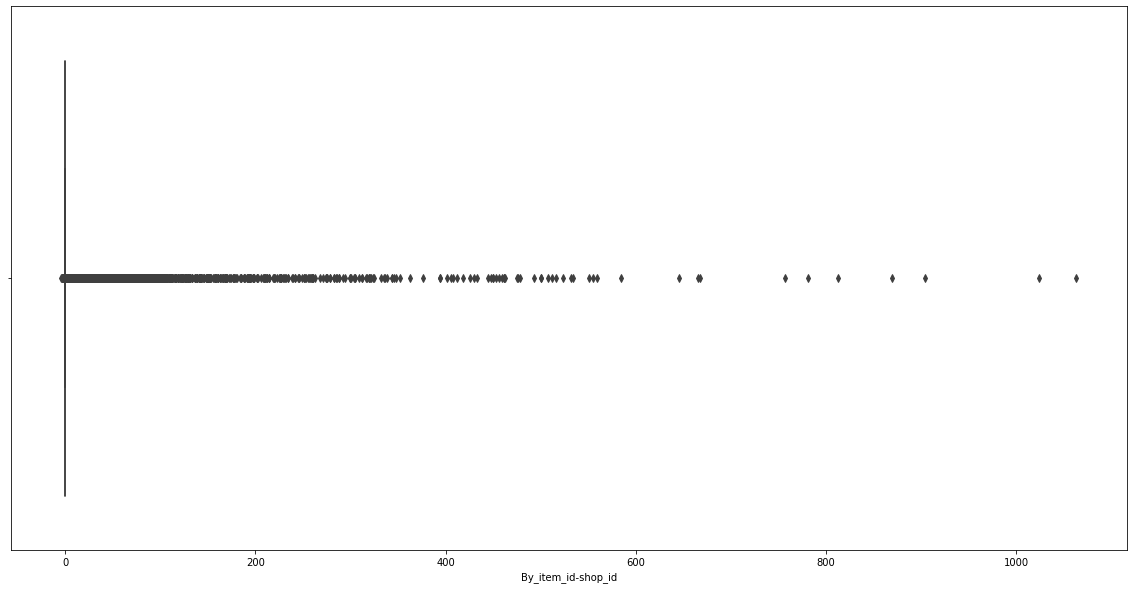

In [ ]:
plt.figure(figsize = (20, 10))

sns.boxplot(x = make_lag_features()['By_item_id-shop_id'])

#sns.boxplot(x = shop_id_month_stack['item_price'], ax = ax2)

#sns.boxplot(x = shop_id_month_stack['USD_Price'], ax = ax3)

#sns.boxplot(x = shop_id_month_stack['revenue'], ax = ax4)

#plt.tight_layout()

# quick XGBoost

In [ ]:
# removing 'year' and 'month' unecessary columns
shop_id_month_stack = make_lag_features()[['item_id', 'shop_id', 'month_id', 'By_item_id-shop_id',
       'By_item_id-shop_id_1_month_ago', 'By_item_id-shop_id_2_month_ago',
       'By_item_id-shop_id_3_month_ago', 'By_item_id-shop_id_4_month_ago',
       'By_item_id-shop_id_5_month_ago', 'By_item_id-shop_id_6_month_ago',
       'By_item_id-shop_id_7_month_ago', 'By_item_id-shop_id_8_month_ago',
       'By_item_id-shop_id_9_month_ago', 'By_item_id-shop_id_10_month_ago',
       'By_item_id-shop_id_11_month_ago', 'By_item_id-shop_id_12_month_ago']]

<ipython-input-67-b02bd1a58772>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.sort_values(by = group_by_cols, inplace = True)


In [ ]:
# checking the df head
shop_id_month_stack.head()

,item_id,shop_id,month_id,By_item_id-shop_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
12,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## You can use this cell to reload the entire training dataset instead of running the notebook above

In [ ]:
# saving dataframe in case runtime error causes problems
#shop_id_month_stack.to_csv(root_path+'full_dataframe.csv')

In [ ]:
#shop_id_month_stack = pd.read_csv(root_path+'full_dataframe.csv')

In [ ]:
# setting training set
X_train = shop_id_month_stack.loc[shop_id_month_stack['month_id'] < 24]
X_train = X_train.drop(['By_item_id-shop_id'], axis = 1)
y_train = shop_id_month_stack.loc[shop_id_month_stack['month_id'] < 24]['By_item_id-shop_id']

# setting testing set
X_val = shop_id_month_stack.loc[shop_id_month_stack['month_id'] == 24]
X_val = X_val.drop(['By_item_id-shop_id'], axis = 1)
y_val = shop_id_month_stack.loc[shop_id_month_stack['month_id'] == 24]['By_item_id-shop_id']

In [ ]:
# checking X_train head
X_train.head()

In [ ]:
# checking X_val head
X_val.head()

,item_id,shop_id,month_id,By_item_id-shop_id_1_month_ago,By_item_id-shop_id_2_month_ago,By_item_id-shop_id_3_month_ago,By_item_id-shop_id_4_month_ago,By_item_id-shop_id_5_month_ago,By_item_id-shop_id_6_month_ago,By_item_id-shop_id_7_month_ago,By_item_id-shop_id_8_month_ago,By_item_id-shop_id_9_month_ago,By_item_id-shop_id_10_month_ago,By_item_id-shop_id_11_month_ago,By_item_id-shop_id_12_month_ago
35,0,0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0,1,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0,3,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,4,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# setting timer
#ts = time.time()

# XGBoost model
model = XGBRegressor(
    max_depth = 10,
    n_estimators = 2000,
    min_child_weight = 300, 
    colsample_bytree = 0.8, 
    subsample = 0.8, 
    eta = 0.5,    
    seed = 42)

# fitting the model to data
model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose = True, 
    early_stopping_rounds = 10)

#print(f'The model took: {time.time() - ts} seconds')

[0]	validation_0-rmse:1.00547	validation_1-rmse:0.36742
[1]	validation_0-rmse:0.95585	validation_1-rmse:0.32417
[2]	validation_0-rmse:0.94105	validation_1-rmse:0.31977
[3]	validation_0-rmse:0.92834	validation_1-rmse:0.32382
[4]	validation_0-rmse:0.92275	validation_1-rmse:0.33011
[5]	validation_0-rmse:0.91558	validation_1-rmse:0.33174
[6]	validation_0-rmse:0.91230	validation_1-rmse:0.34522
[7]	validation_0-rmse:0.90848	validation_1-rmse:0.33442
[8]	validation_0-rmse:0.90673	validation_1-rmse:0.32981
[9]	validation_0-rmse:0.90412	validation_1-rmse:0.32152
[10]	validation_0-rmse:0.90179	validation_1-rmse:0.31649
[11]	validation_0-rmse:0.89840	validation_1-rmse:0.32875
[12]	validation_0-rmse:0.89521	validation_1-rmse:0.32841


In [ ]:
# predicting X_val
y_pred = model.predict(X_val).clip(0, 20)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

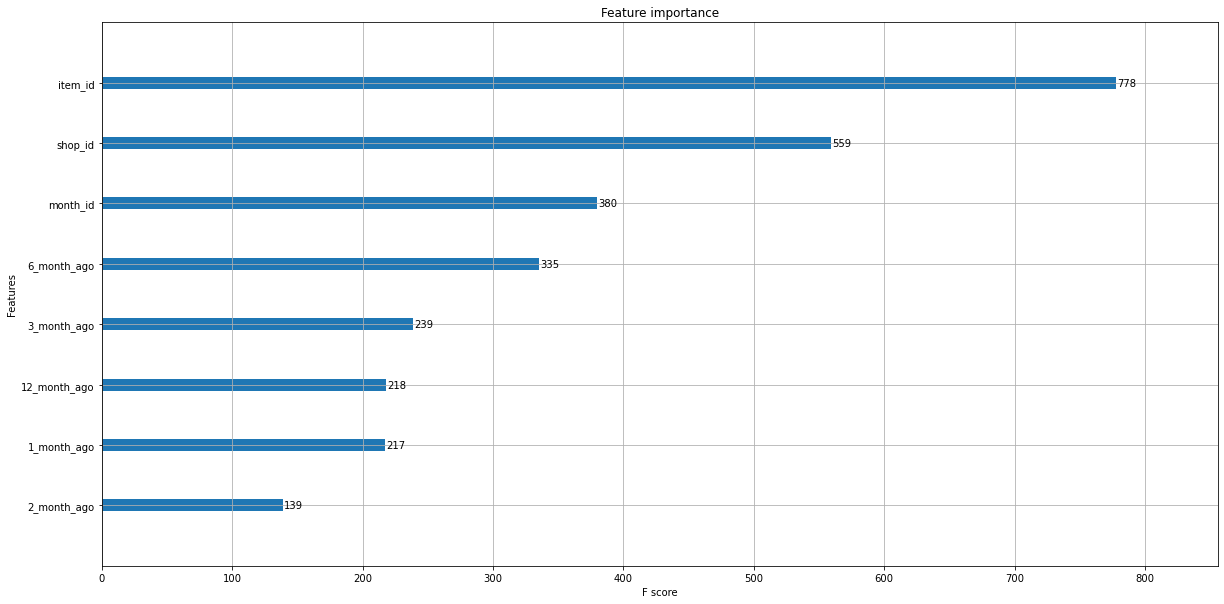

In [ ]:
# creating function to plot features
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

plot_features(model, (20,10))

#plt.savefig('drive/MyDrive/Camp Jupyter/predict_future_sales_data/xgboost.png')

Text(0.5, 1.0, 'Actual vs. predictions scatterplot')

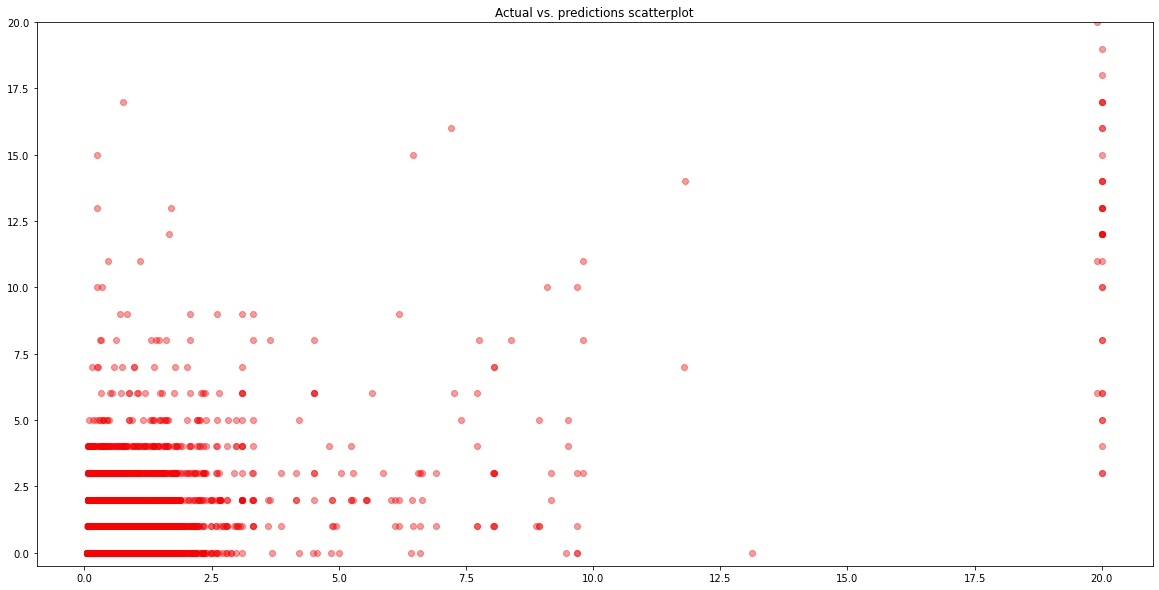

In [ ]:
# scatterplot predictions and actual
plt.figure(figsize = (20, 10))
plt.scatter(x = y_pred, y = y_val, c = 'r', alpha = 0.4)
#plt.xlim(0, 5)
plt.ylim(-0.5, 20)
plt.title('Actual vs. predictions scatterplot')
#plt.savefig('drive/MyDrive/Camp Jupyter/predict_future_sales_data/xgboost_scatter.png')

In [ ]:
# saving model as pickle file
import pickle

xgboost_pickle = 'xgboost_pickle.pkl'
with open(xgboost_pickle, 'wb') as file:
  pickle.dump(model, file)

## Matching output to test_df for submission

In [ ]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
shop_id_month_stack.head()

NameError: ignored

In [ ]:
len(test_df)

214200

In [ ]:
# creating new 
shop_id_month_stack_last_month = shop_id_month_stack[shop_id_month_stack['month_id'] == 24]

In [ ]:
test_df_merged = pd.merge(test_df, shop_id_month_stack_last_month, how = 'left',on = ['item_id','shop_id'])

test_df_merged.fillna(0, inplace = True)

In [ ]:
shop_id_month_stack_last_month[shop_id_month_stack_last_month['item_id'] == 5320]

,Unnamed: 0,item_id,shop_id,item_cnt_month_shop_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id


In [ ]:
test_df_clean = test_df_merged.drop(['Unnamed: 0','ID','item_cnt_month_shop_id'], axis = 1)

In [ ]:
test_df_merged.head()

,ID,shop_id,item_id,Unnamed: 0,item_cnt_month_shop_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id
0,0,5,5037,10171655.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,10579895.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0
3,3,5,5232,10577735.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_df_merged.isnull().sum()

ID                            0
shop_id                       0
item_id                       0
Unnamed: 0                16212
item_cnt_month_shop_id    16212
1_month_ago               16212
2_month_ago               16212
3_month_ago               16212
6_month_ago               16212
12_month_ago              16212
month_id                  16212
dtype: int64

In [ ]:
test_df_merged.head()

,ID,shop_id,item_id,Unnamed: 0,item_cnt_month_shop_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id
0,0,5,5037,10171655.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,10579895.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0
3,3,5,5232,10577735.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(test_df_merged)

214200

In [ ]:
test_df_clean.head()

,shop_id,item_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id
0,5,5037,0.0,0.0,0.0,0.0,0.0,24.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,1.0,0.0,0.0,24.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,24.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_df_clean['month_id']=25

In [ ]:
test_df_clean=test_df_clean[['item_id','shop_id','1_month_ago', '2_month_ago', '3_month_ago',
       '6_month_ago', '12_month_ago', 'month_id']]

In [ ]:
# predicting X_val
y_pred_test = model.predict(test_df_clean).clip(0, 20)

In [ ]:
len(y_pred_test)

214200

sample_df=pd.read_csv('submission_1.csv')

len(sample_df)

sample_df

In [ ]:
test_df_merged.head()

,ID,shop_id,item_id,Unnamed: 0,item_cnt_month_shop_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id
0,0,5,5037,10171655.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,10579895.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0
3,3,5,5232,10577735.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(test_df_clean)

214200

In [ ]:
test_df_clean_for_submission = test_df_clean.copy()

In [ ]:
test_df_clean_for_submission['ID'] = np.arange(0,214200)

In [ ]:
len(test_df_clean_for_submission)

214200

In [ ]:
len(y_pred_test)

214200

In [ ]:
test_df_clean_for_submission['item_cnt_month'] = y_pred_test

In [ ]:
test_df_clean_for_submission.head()

,item_id,shop_id,1_month_ago,2_month_ago,3_month_ago,6_month_ago,12_month_ago,month_id,ID,item_cnt_month
0,5037,5,0.0,0.0,0.0,0.0,0.0,25,0,0.067603
1,5320,5,0.0,0.0,0.0,0.0,0.0,25,1,0.067603
2,5233,5,0.0,0.0,1.0,0.0,0.0,25,2,0.186256
3,5232,5,0.0,0.0,0.0,0.0,0.0,25,3,0.067603
4,5268,5,0.0,0.0,0.0,0.0,0.0,25,4,0.067603


In [ ]:
submission_df=test_df_clean_for_submission[['ID','item_cnt_month']]

In [ ]:
submission_df.head()

,ID,item_cnt_month
0,0,0.067603
1,1,0.067603
2,2,0.186256
3,3,0.067603
4,4,0.067603


In [ ]:
len(submission_df)

214200

submission_df_int=submission_df.copy()

submission_df_int['item_cnt_month']=np.round(submission_df_int['item_cnt_month'])

In [ ]:
submission_df.to_csv('sample_2021-0424.csv',index=False)

In [ ]:
submission_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.122681
std,61834.358168,0.350130
min,0.000000,0.058481
25%,53549.750000,0.067944
50%,107099.500000,0.069786
75%,160649.250000,0.093864
max,214199.000000,20.000000


In [ ]:
#submission_df_int.to_csv('sample_2021-0424_int.csv',index=False)

In [ ]:
submission_df_int.head()

,ID,item_cnt_month
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
len(submission_df_int[submission_df_int['item_cnt_month']!=0])

1404

In [ ]:
len(y_pred)

1263540

In [ ]:
xg_output = pd.DataFrame(y_pred)

In [ ]:
print(len(xg_output))
print(len(X_val))

NameError: ignored

In [ ]:
xg_output['ID'] = range(0, 210589)

NameError: ignored

In [ ]:
X_val['item_id'].nunique()

In [ ]:
xg_output.rename({0:'item_cnt_month'}, inplace=True, axis=1)

NameError: ignored

In [ ]:
xg_output = xg_output.set_index('ID')

In [ ]:
xg_output.to_csv('drive/MyDrive/Camp Jupyter/predict_future_sales_data/submission_1.csv')

Submission file must have 214200 rows!

GridSearchCV and RandomSearchCV



In [ ]:
def algo_pipeline(X_train, X_val, y_train, y_val, model, param_grid, cv=10, scoring_fit='neg_mean_squared_error', do_probabilities=False):
  rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=cv, scoring=scoring_fit, verbose=2)
  fitted_model = rs.fit(X_train,y_train)
  if do_probabilities:
    pred = fitted_model.predict_proba(X_test)
  else:
    pred = fitted_model.predict(X_test)

  return fitted_model, pred

In [ ]:
model = XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8], # Denotes the fraction of columns to be randomly samples for each tree.Typical values: 0.5-1
    'max_depth': [15,20,25], # Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.Should be tuned using CV. Typical values: 3-10
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9] # Denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values: 0.5-1
}

model, pred = algo_pipeline(X_train, X_val, y_train, y_val, model, param_grid, cv = 10)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

# Feature selection

Make features for MA: 7, 30, 60, 90 days, season, month

Convert into categorical - Store, Item

In [ ]:
# item names with their revenue and sold count
item_names = salestrain_df_combined.groupby('item_name').agg({'revenue':'sum', 'item_cnt_day':'count'}).reset_index().rename(columns={'item_name': 'Item Name', 'revenue': 'Revenue', 'item_cnt_day': 'Number of Sales'})
item_names.head()

NameError: ignored

In [ ]:
# top 10 items based on their revenue
top10_revenue = item_names.nlargest(10, 'Revenue')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_revenue, hue='Number of Sales', x='Revenue', y='Item Name')
plt.title("Top 10 Items based on Revenue including their Number of Sales")
plt.show()

In [ ]:
# top 10 items based on their revenue
top10_sales = item_names.nlargest(10, 'Number of Sales')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_sales, x='Number of Sales', y='Item Name', hue='Revenue')
plt.title("Top 10 Items based on Sales including their Revenue")
plt.show()

In [ ]:
# category names and how many items in it.
category_names = salestrain_df_combined.groupby(['item_category_name']).agg({'item_name':'count'}).reset_index().rename(columns={'item_category_name': 'Category Name','item_name': 'Number of Items'})
category_names.head()

In [ ]:
#Find total sales by item
total_sales_by_item = salestrain_df_combined.groupby('item_id')['item_cnt_day'].sum().reset_index()

#Sort descending
total_sales_by_item.sort_values(by='item_cnt_day',ascending=False,inplace=True)
total_sales_by_item.head()

NameError: ignored

In [ ]:
#Merge together so we can get item_name with total sales values
total_sales_by_item_with_name = total_sales_by_item.merge(items_df[['item_name','item_id']],on='item_id')
total_sales_by_item_with_name.head()

In [ ]:
total_sales_by_item['item_cnt_day'].iloc[:10]

In [ ]:
# updated scatterplot showing top 20 best selling items day to day
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(y = total_sales_by_item['item_cnt_day'].iloc[:20], x = total_sales_by_item['item_id'].iloc[:20])
plt.xlabel('Item ID')
plt.ylabel('Item count per day')
plt.show()

## Recommendation Engine

In [ ]:
# Get sales by item, by date - again, not very exciting,so I also used fillna()
sales_totals_by_day = salestrain_df_combined.pivot_table(index='item_id',columns=['year', 'month', 'day'],values='item_cnt_day').fillna(0)

In [ ]:
# Clean up the multi-level index
sales_totals_by_day.columns = sales_totals_by_day.columns.droplevel().droplevel()

In [ ]:
sales_totals_by_day.head()

In [ ]:
# Shape of the resulting DF - items x days
sales_totals_by_day.shape

In [ ]:
#Transpose this
sales_totals_by_day_transposed = sales_totals_by_day.transpose()

In [ ]:
sales_totals_by_day_transposed.head()

In [ ]:
# Recommendation engine - find the closest matches to an item in terms of daily sales
# Similar to finding similar movies based on movie rating

#Select a popular item
selected_item = 2808

In [ ]:
#Pull out the column of that day's sales
selected_item_sales = sales_totals_by_day_transposed[selected_item]

In [ ]:
#Run correlation with every other column to find similar sales patterns
similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)

In [ ]:
#Convert from a series to a DF
similarItems_df = pd.DataFrame(similarItems)

In [ ]:
similarItems_df.head()

NameError: ignored

In [ ]:
#Rename columns
similarItems_df.columns=['similarity']

In [ ]:
similarItems_df.head()

In [ ]:
#Merge back item names
similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')

In [ ]:
#Sort
similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)

In [ ]:
#The top results for item 2808 seem to make some sense (games), but they also include programming books and other things-inconclusive?
similarItems_df_sorted.head(20)

In [ ]:
#Function to return the values:

def find_similar_based_on_daily_sales(selected_item,sales_totals_by_day_transposed=sales_totals_by_day_transposed):
    selected_item_sales=sales_totals_by_day_transposed[selected_item]
    similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)
    similarItems_df=pd.DataFrame(similarItems)
    similarItems_df.columns=['similarity']
    similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')
    similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)
    print(similarItems_df_sorted.head(20))

In [ ]:
find_similar_based_on_daily_sales(2808)

In [ ]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(20949)

In [ ]:
#What is similar to minecraft?
find_similar_based_on_daily_sales(4870)

In [ ]:
#This item averaged 5 sales per day, max of 35, so it wasn't distorted by one overwhelmingly high corporate order
sales_totals_by_day_transposed[20949].describe()

## Rolling window K-fold cross-validation

In [ ]:
salestrain_df_combined.columns

In [ ]:
# setting X as date col and y as revenue col to be split
X = salestrain_df_combined['date']
y = salestrain_df_combined['revenue']

In [ ]:
# creating the time series split, one split for every month in the year
tscv = TimeSeriesSplit(n_splits = 12)

In [ ]:
# looping through every time series split 
for train_index, test_index in tscv.split(X):
  print(f'TRAIN SHAPE: {train_index.shape} TEST SHAPE: {test_index.shape}')
    
  #X_train, X_test = X[train_index], X[test_index]
  #y_train, y_test = y[train_index], y[train_index]

## Removing features with low variance

In [ ]:
salestrain_df_combined.columns

In [ ]:
train_set = salestrain_df_combined.drop(columns = ['revenue'])

In [ ]:
# mapping date col to ordinal for use with VarianceThreshold
train_set['date'] = train_set['date'].map(dt.datetime.toordinal)

In [ ]:
for col in ['item_name', 'item_category_name', 'shop_name']:
   train_set[col] = LabelEncoder().fit_transform(train_set[col])

In [ ]:
test_set = salestrain_df_combined['revenue']

In [ ]:
train_set.dtypes

NameError: ignored

In [ ]:
test_set.shape

In [ ]:
# creating the Variance Threshold and setting variance to 10 -> can mess around with this number
threshold = VarianceThreshold(threshold = 10)

In [ ]:
# fit transforming variance threshold to train set
high_variance = threshold.fit(train_set)

In [ ]:
# seeing which cols do not have high variance
train_set.columns[high_variance.get_support()]

In [ ]:
# seeing which cols have low variance
constant_cols = [column for column in train_set.columns if column not in train_set.columns[high_variance.get_support()]]
print(f'The columns with low(ish) variance is: {constant_cols}')

All of our features have high variance, therefore they don't have to be removed.

## K-Means clustering

In [ ]:
#salestrain_df.head()
salestrain_df = salestrain_df.drop('date', axis=1)

In [ ]:
salestrain_df.head(10)

NameError: ignored

In [ ]:
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(np.array(salestrain_df))

# Calculate the cluster labels: labels
labels = pipeline.predict(salestrain_df)

# Create a DataFrame with labels and prices as columns: salestrain_df
#salestrain_df = pd.DataFrame({'item_price': item_price, 'item_cnt_day': item_cnt_day})

# Create crosstab: ct
ct = pd.crosstab(salestrain_df['item_price'], salestrain_df['item_cnt_day'])

# Display ct
print(ct.sort_values('item_price'))

In [ ]:
# plotting clusters
plt.figure(figsize=(20, 10))
plt.plot(ct)
plt.show()

In [ ]:
# reshaping values to workable vector
dfx = salestrain_df.values.reshape(1, -1)
dfy = salestrain_df.values.reshape(1, -1)

In [ ]:
# WHY DELETING?

# delete part 1
#dfx = np.delete(dfx, 0)
#dfy = np.delete(dfy, 0)

In [ ]:
# WHY DELETING?

# delete part 2
#dfx = np.delete(dfx, 1)
#dfy = np.delete(dfy, 1)

In [ ]:
print(f'dfx shape: {dfx.shape}')
print(f'dfy shape: {dfy.shape}')

In [ ]:
# setting variables train test split
X = dfx
y = dfy

# running logistic regression baseline
#logreg =  LogisticRegression()
#X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# checking train, test shapes
#print(f'X_train shape: {X_train.shape}')
#print(f'y_train shape: {y_train.shape}')
#print(f'X_test shape: {X_test.shape}')
#print(f'y_test shape: {y_test.shape}')

In [ ]:
#
#logreg.fit(X_train, y_train)
#y_pred =logreg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [ ]:
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(X_train, y_train)
#clf.predict(X_test)
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

## Categorical features
Created different datasets with OHE encoding, mean/target encoding, frequency encoding and hash encoding

#### OHE
OHE does not work, memory issue due to the fact that there are 22150 unique item names.

In [ ]:
# item_name unique 22150 values --> colossal number of columns, not the best option since shape will be (2935846, 21787)
cols_to_encode = ['item_category_name', 'shop_name']
salestrain_df_ohe = salestrain_df_combined.copy()

# change float64 to float16 and int64 to int16 to reduce memory usage
salestrain_df_ohe['item_price'] = salestrain_df_ohe['item_price'].astype(np.float16)
cols_int = salestrain_df_ohe.select_dtypes('int64').columns
for col in cols_int:
    salestrain_df_ohe[col] = salestrain_df_ohe[col].astype(np.int16)

# OHE
salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=['item_category_name', 'shop_name'], columns=['item_category_name', 'shop_name'], dtype=np.int16)

# renaming
item_cat_iter = 0
shop_iter = 0
for col in salestrain_df_ohe.columns:
    if col.startswith('item_category_name_'):
        salestrain_df_ohe.rename(columns={col: "item_category_name_" + str(item_cat_iter)}, inplace=True)
        item_cat_iter += 1
    if col.startswith('shop_name_'):
        salestrain_df_ohe.rename(columns={col: "shop_name_" + str(shop_iter)}, inplace=True)
        shop_iter += 1

# sounds good doesn't work: too many different categories for item_name
# cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
# for col in cols_to_encode:
#     salestrain_df_ohe = pd.get_dummies(salestrain_df_ohe, prefix=[col], columns=[col])
#     ohe_enc = OneHotEncoder()
#     ohe_enc = ohe_enc.fit_transform(salestrain_df_ohe[[col]]).astype(np.int16).toarray()
#     encoded_cols = pd.DataFrame(ohe_enc)
#     salestrain_df_ohe = pd.concat([salestrain_df_ohe, encoded_cols], axis = 1)
    
salestrain_df_ohe.head()

NameError: ignored

#### Frequency encoder
Set categorical features to frequency they occur in the dataset

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_freq = salestrain_df_combined.copy()

# grouping by frequency
for col in cols_to_encode:
    freq = salestrain_df_freq.groupby(col).size()/len(salestrain_df_freq)
    salestrain_df_freq.loc[:, "{}_freq_encode".format(col)] = salestrain_df_freq[col].map(freq)
    
salestrain_df_freq.drop(columns=cols_to_encode, inplace=True)
salestrain_df_freq.head()

#### Hashing
Use hash functions to translate categorical feature to numeric features



The values itself don't really say anything tbh, but the combination of the columns are mapped to one value within the original categorical feature
So for example, if you would have a categorical feature, the hash function maps this string to an X number of integers

In [ ]:
# currently, number of bits used to represent features is a bit random (2^x where the result is bigger than number of unique values)
# this takes quite a bit of time to run
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
nr_bits = [6, 7, 15]
salestrain_df_hash = salestrain_df_combined.copy()

for bits, col in zip(nr_bits, cols_to_encode):
    print(bits, col)
    h = FeatureHasher(n_features=bits, input_type='string') 
    hashed_col = h.fit_transform(salestrain_df_hash[col].astype(str)).toarray()
    salestrain_df_hash = pd.concat([salestrain_df_hash, pd.DataFrame(hashed_col)], axis = 1)
    for i in range(bits):
        salestrain_df_hash.rename(columns={i: col + "_" + str(i)}, inplace=True)
    print(col + " done")
        
salestrain_df_hash.head()

#### Target/mean encoding
Seems to work very well in lots of applications, but can cause overfitting. Maybe use (stratified) KFold?

In [ ]:
cols_to_encode = ['item_name', 'item_category_name', 'shop_name']
salestrain_df_mean = salestrain_df_combined.copy()

# simple method, probably should do this with item_cnt_month though, should create that feature
for col in cols_to_encode:
    mean_enc = salestrain_df_mean.groupby(col)['item_cnt_day'].mean()
    salestrain_df_mean.loc[:, str(col + "_mean_encoded")] = salestrain_df_mean[col].map(mean_enc)
    
salestrain_df_mean.head()

# DBSCAN (and other clustering)


In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
# creating DBSCAN data copy
salestrain_DBSCAN = salestrain_df_combined.copy()
X = salestrain_DBSCAN['date']
y = salestrain_DBSCAN['revenue']


salestrain_DBSCAN = salestrain_DBSCAN.drop(columns=['date'])

In [ ]:
# showing sales pre clustering
plt.figure(figsize=(20,10))
plt.scatter(X, y, s=15, color='grey')
plt.show()

TRY CLUSTERING PART 2 WITH MITCHELLS CATEGORICAL HASHING 

In [ ]:
#salestrain_df_hash.head()
salestrin_DBSCAN = salestrain_df_hash.drop(columns=['date', 'item_name', 'item_category_name','shop_name'], axis=1)
salestrain_DBSCAN.head()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(salestrain_DBSCAN)

In [ ]:
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(salestrain_DBSCAN[0,1])

need to determine 2 things with DBSCAN, epsilon and minPoints

RandomSearchCV



# good resources

dbscan!

https://www.google.com/search?q=dbscan+python&sxsrf=ALeKk01MOpqS6o2Y-gJotJVswEPIS6thPA%3A1616814191706&ei=b6BeYL68KsKHggfYxrfgDw&oq=dbscan&gs_lcp=Cgdnd3Mtd2l6EAMYAjIECCMQJzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIECAAQQzIHCAAQsQMQQzICCAAyBAgAEEMyAggAOgoILhDHARCvARBDOgoILhDHARCjAhBDOggILhCxAxCDAToNCC4QsQMQxwEQowIQQzoKCAAQsQMQgwEQQ1DFalilcmDHiwFoAHACeACAAdYLiAHZFZIBDTAuNC4xLjUtMS4wLjGYAQCgAQGqAQdnd3Mtd2l6wAEB&sclient=gws-wiz

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

https://www.geeksforgeeks.org/implementing-dbscan-algorithm-using-sklearn/

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

aws colab integration

https://medium.com/@lily_su/accessing-s3-bucket-from-google-colab-16f7ee6c5b51

https://python.plainenglish.io/how-to-load-data-from-aws-s3-into-google-colab-7e76fbf534d2

https://stackoverflow.com/questions/50978361/how-to-load-s3-open-dataset-in-google-colaboratory